# Vanilla Neural Network
Undersample data and use Sliding Window approach  
Hope to generate 20+ points

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import math

Using TensorFlow backend.
/Users/samcohen/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load dataset

In [2]:
dataframe = pd.read_excel('../data/130N_Cycles_1-47.xlsx')

In [6]:
#Fix a random seed to allow for reproducible results
np.random.seed(7)

### Clean data
1) Remove time dimension as loads are recorded at uniform intervals  
2) Remove misread load  
3) How to handle negatives??


In [46]:
#Remove time dimension as loads are uniform
df = dataframe.drop('time', 1)

#Remove second load value as it was a misread
df = df.drop(df.index[1])

#Store as a numpy ndarray
data = df.values
data = data.astype('float32')

#data = data[0:int(len(data)/10)]

print(max(data))
print(len(data))

[ 133.59475708]
170100


### Undersample and visualize data
* Challenge: Removing even a couple values can drastically distort cycles as peaks and troughs are narrow  
* Maybe carefully select points to remove?
* Attempt to remove noise while retaining the overall structure of the cycles

In [1]:
undersampleVal = 10

fig=plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')

#Plot original data
plt.plot(data)

#Undersample by taking every 10th point
dataset = data[0::undersampleVal]
print(max(dataset))
#Plot undersampled data
undersampleX = [i*undersampleVal for i in range(len(dataset))]
print(max(undersampleX))
#print(undersampleX)

plt.plot(undersampleX, dataset)



NameError: name 'plt' is not defined

## Split data into training validation and testing sets
* Split into 67% Train and 33% Validation 
* Probably a better function to use here?  
* Probably should split into train, val, AND test




In [48]:
train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

11396 5614


## Transform Data
Transform our single column of data into a two-column dataset:
* First column: array of time `(t - look_back)` --> `(t)` loads
* second column: array of time `(t)` --> `(t + look_ahead)` loads
* look_back: number of previous time steps to use as input
* look_ahead: number of time steps to predict

In [61]:
def transform_dataset(dataset, look_back = 3, look_ahead = 1):
    
    dataX = []
    dataY = []
    
    #Where i is the first force and the next look_back are in X and i+look_back -> i+look_back + look_ahead are Y
    for i in range(len(dataset) - look_back - look_ahead):
        #print(i)

        
        #The ", 0" slice formats the list as a row vector
        inputVals = dataset[i : i+look_back, 0] 
        outputVals = dataset[i+look_back : i+look_back + look_ahead,0]
        
        dataX.append(inputVals)
        dataY.append(outputVals)
        
    return np.array(dataX), np.array(dataY)
        

In [86]:
#Build the train and test datasets
look_back = 10
look_ahead = 1
trainX, trainY = transform_dataset(train, look_back, look_ahead)
print(len(trainX))
testX, testY = transform_dataset(test, look_back, look_ahead)

11385


## Build Shallow Vanilla Neural Network

* The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data


### Develop some metrics of percent accuracy

In [87]:
import keras.backend as K
import math
def percenError(y_true, y_pred):
    
    return y_true#100 * abs(y_true - y_pred)/y_true
    
#     if abs(y_true - y_pred) < 0.5:
#         return 0
#     else:
#         return 1
    


In [88]:
model = Sequential()

#Input = look_back forces, two hidden layers of neurons and look_ahead output
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(look_ahead))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=40, verbose=2)

Epoch 1/200
 - 1s - loss: 112.5671
Epoch 2/200
 - 0s - loss: 0.4628
Epoch 3/200
 - 0s - loss: 0.4426
Epoch 4/200
 - 0s - loss: 0.4654
Epoch 5/200
 - 0s - loss: 0.4474
Epoch 6/200
 - 0s - loss: 0.4192
Epoch 7/200
 - 0s - loss: 0.4444
Epoch 8/200
 - 0s - loss: 0.3976
Epoch 9/200
 - 0s - loss: 0.4176
Epoch 10/200
 - 0s - loss: 0.4051
Epoch 11/200
 - 0s - loss: 0.4408
Epoch 12/200
 - 0s - loss: 0.4776
Epoch 13/200
 - 0s - loss: 0.3965
Epoch 14/200
 - 0s - loss: 0.3866
Epoch 15/200
 - 0s - loss: 0.3753
Epoch 16/200
 - 0s - loss: 0.3844
Epoch 17/200
 - 0s - loss: 0.3632
Epoch 18/200
 - 0s - loss: 0.4125
Epoch 19/200
 - 0s - loss: 0.4414
Epoch 20/200
 - 0s - loss: 0.3444
Epoch 21/200
 - 0s - loss: 0.3390
Epoch 22/200
 - 0s - loss: 0.3556
Epoch 23/200
 - 0s - loss: 0.3581
Epoch 24/200
 - 0s - loss: 0.3278
Epoch 25/200
 - 0s - loss: 0.3078
Epoch 26/200
 - 0s - loss: 0.3230
Epoch 27/200
 - 0s - loss: 0.3337
Epoch 28/200
 - 0s - loss: 0.2528
Epoch 29/200
 - 0s - loss: 0.2924
Epoch 30/200
 - 0s - 

### Estimate Model Performance

In [89]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

0.106072806384
Train Score: 0.11 MSE (0.33 RMSE)
Test Score: 0.07 MSE (0.27 RMSE)


## Generate Predictions & Visualize

In [83]:
#Generate Predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

### Shift predictions to align with baseline data
* Baseline data covers all available `x` values.   
* However, we only start predicting values after `look_back` number of `x` values are used.  
* Had we just plotted, then our predictions for a given x would be shifted backwards `look_back` units on the x-axis.

1) Create random data of same shape as our data (`np.empty_like`).  
2) Clear out all values.  
3) Store the predictions at the appropriate indices to align.

In [85]:
#Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan

trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
#Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
print(len(testPredict))
#Start index includes starts after train predictions plus the look_back for test predictions + 1 why??


testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1,:] = testPredict


ValueError: could not broadcast input array from shape (11384,2) into shape (11384,1)

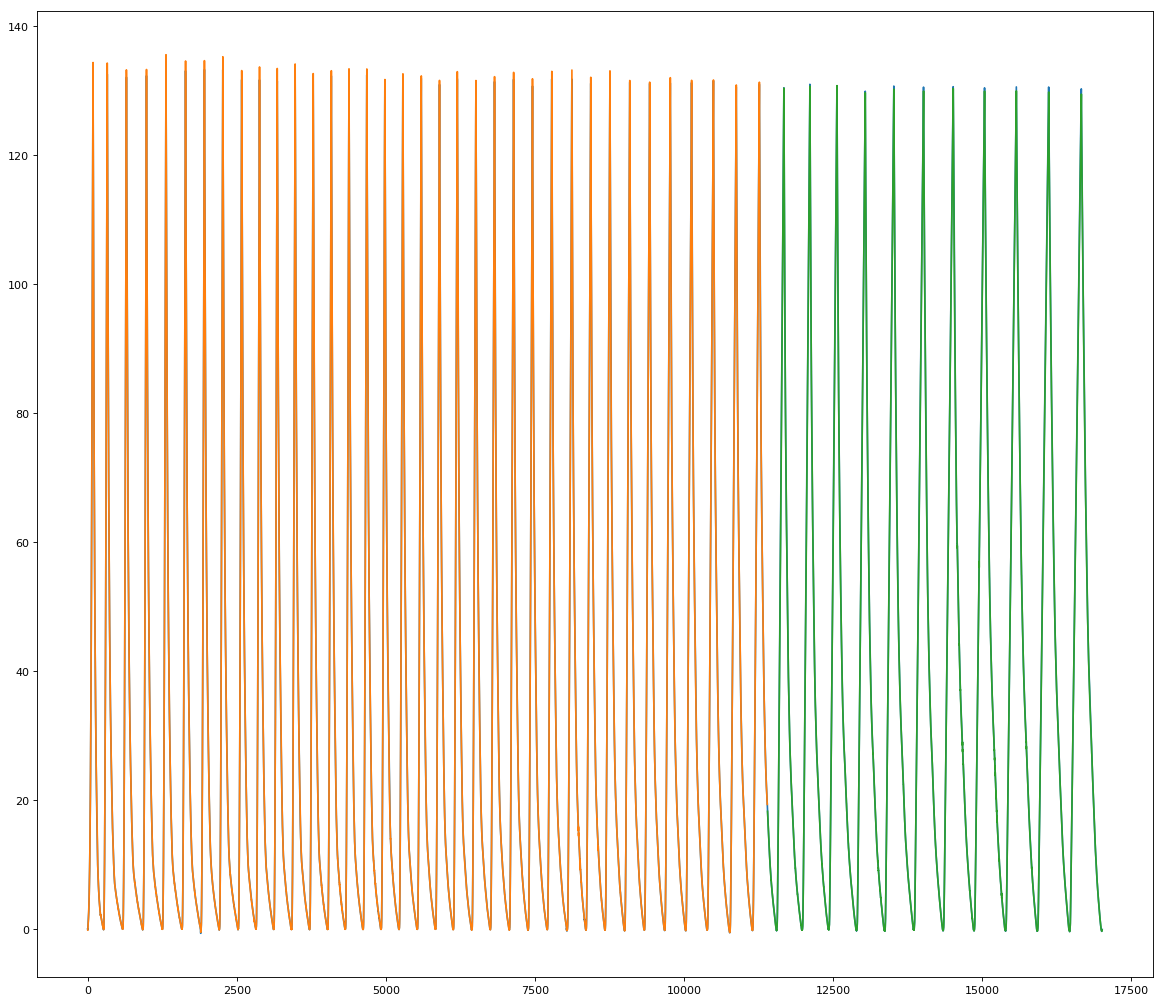

In [68]:
#Plot baseline and training/test predictions
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()